In [25]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

In [43]:
df = pd.read_json("dataframe.json")
df['processed_text_only'] = df['processed_text'].apply(lambda x: " ".join(x[1]))
df['processed_desc_only'] = df['processed_desc'].apply(lambda x: " ".join(x[1]) if x else "")
df['annotated_text_only'] = df['processed_text'].apply(lambda x: " ".join([f"{z}({y})" for z, y in x[0]]))
df['annotated_desc_only'] = df['processed_desc'].apply(lambda x: " ".join([f"{z}({y})" for z, y in x[0]] if x else ""))
df['processed_all'] = df[["processed_text_only", "processed_desc_only"]].apply(" ".join, axis=1)
df['annotated_all'] = df[["annotated_text_only", "annotated_desc_only"]].apply(" ".join, axis=1)
df['all'] = df[["annotated_all", "processed_all"]].apply(" ".join, axis=1)
df.head()
X = df["processed_all"]
Y = df['cat']

Precision : 0.9642857142857143
Recall : 0.9642857142857143
F1 Score : 0.9523809523809523
Accuracy : 0.9642857142857143
Accuracy per categories : {'Comics_characters': 1.0, 'City': 1.0, 'Transport': 1.0, 'Sports_teams': 1.0, 'Sportspeople': 1.0, 'Written_communication': 1.0, 'Universities_and_colleges': 1.0, 'Building': 1.0, 'Astronauts': 0.9642857142857143, 'Monuments_and_memorials': 1.0, 'Companies': 1.0, 'Airports': 1.0, 'Foods': 1.0, 'Politicians': 0.9642857142857143}


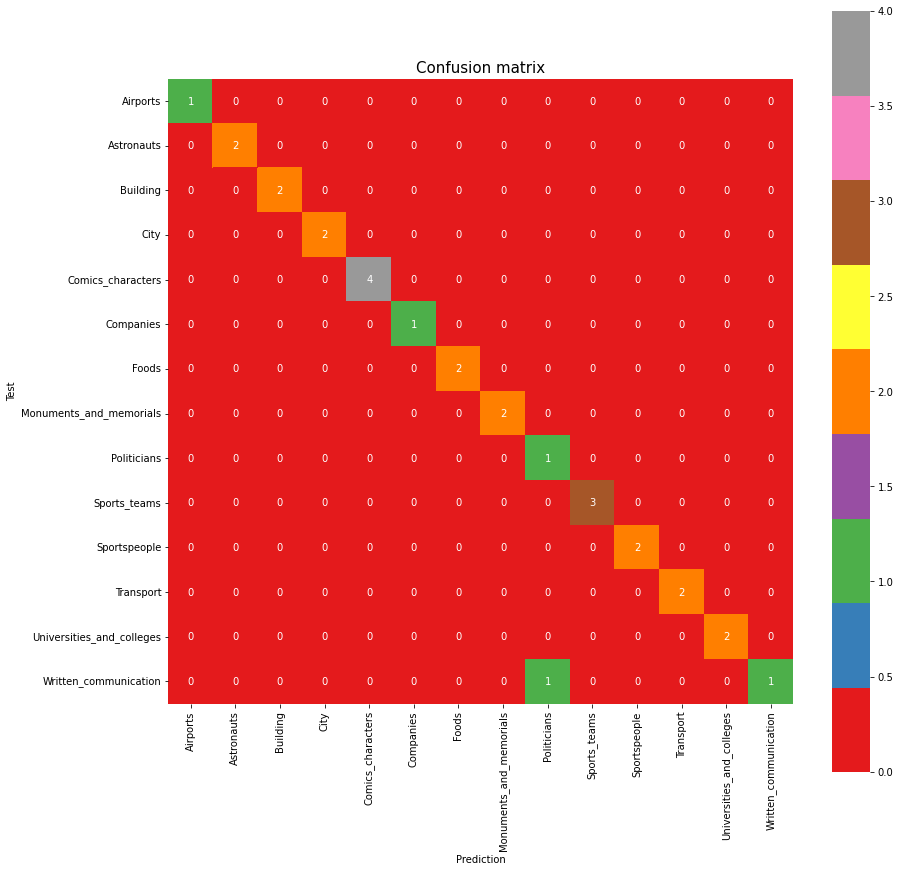

In [53]:
def compute(df, x="processed_all", y='cat', max_iter=15):
    X = df[x]
    Y = df[y]
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)
    tfidf_vectorizer = TfidfVectorizer(max_features=8000,
                                       use_idf=True,
                                       stop_words='english',
                                       tokenizer=nltk.word_tokenize,
                                       ngram_range=(1, 3))
    X_train_vec = tfidf_vectorizer.fit_transform(X_train)
    X_test_vec = tfidf_vectorizer.transform(X_test)
    # Create a Perceptron object
    classifier = Perceptron(max_iter=max_iter)
    # Train the model on the training data
    classifier.fit(X_train_vec, Y_train)
    # Test the model on the test data
    Y_pred = classifier.predict(X_test_vec)
    return Y_test, Y_pred


def stats(Y_test, Y_pred):
    prec, rec, f1, _ = precision_recall_fscore_support(
        Y_test,
        Y_pred,
        average="macro",
        zero_division=0
    )
    cm = pd.crosstab(Y_test, Y_pred)
    conf = confusion_matrix(Y_test, Y_pred)
    cat_acc = {}
    for idx, cls in enumerate(set(Y_test)):
        tn = np.sum(np.delete(np.delete(conf, idx, axis=0), idx, axis=1))
        tp = conf[idx, idx]
        cat_acc[cls] = (tp + tn) / np.sum(conf)

    return {"precision": prec, "recall": rec, "f1_score": f1, "accuracy": accuracy_score(Y_test, Y_pred),
            "confusion_matrix": cm, "category_accuracy": cat_acc}


def complete(df, x="processed_all", y='cat', max_iter=15):
    Y_test, Y_pred = compute(df, x, y, max_iter)
    stat = stats(Y_test, Y_pred)
    cm = stat['confusion_matrix']
    unique = len(set(Y_pred))
    plt.figure(figsize=(unique, unique))
    sns.heatmap(cm, annot=True, square=True, cmap="Set1")
    plt.ylabel("Test")
    plt.xlabel("Prediction")
    plt.title("Confusion matrix", size=15)
    print(f"Precision : {stat['precision']}")
    print(f"Recall : {stat['recall']}")
    print(f"F1 Score : {stat['f1_score']}")
    print(f"Accuracy : {stat['accuracy']}")
    print(f"Accuracy per categories : {stat['category_accuracy']}")
    plt.show()


complete(df)

Precision : 0.8785714285714287
Recall : 0.9285714285714286
F1 Score : 0.8968253968253969
Accuracy : 0.9285714285714286
Accuracy per categories : {'Comics_characters': 1.0, 'City': 1.0, 'Transport': 1.0, 'Sports_teams': 1.0, 'Sportspeople': 0.9642857142857143, 'Written_communication': 0.9642857142857143, 'Universities_and_colleges': 1.0, 'Building': 1.0, 'Astronauts': 1.0, 'Monuments_and_memorials': 1.0, 'Companies': 1.0, 'Airports': 1.0, 'Foods': 1.0, 'Politicians': 0.9285714285714286}


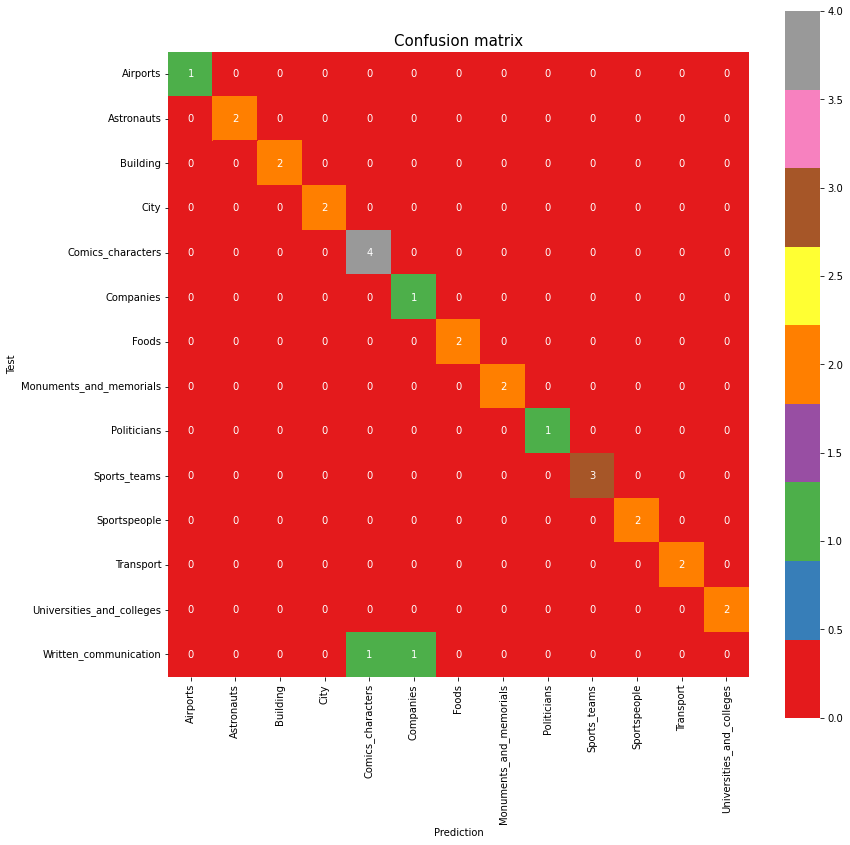

In [54]:
complete(df, x='text')

Precision : 0.755952380952381
Recall : 0.8214285714285714
F1 Score : 0.7547619047619047
Accuracy : 0.75
Accuracy per categories : {'Comics_characters': 1.0, 'City': 1.0, 'Transport': 1.0, 'Sports_teams': 1.0, 'Sportspeople': 0.8571428571428571, 'Written_communication': 1.0, 'Universities_and_colleges': 0.9642857142857143, 'Building': 1.0, 'Astronauts': 0.8928571428571429, 'Monuments_and_memorials': 1.0, 'Companies': 1.0, 'Airports': 0.8571428571428571, 'Foods': 1.0, 'Politicians': 0.9285714285714286}


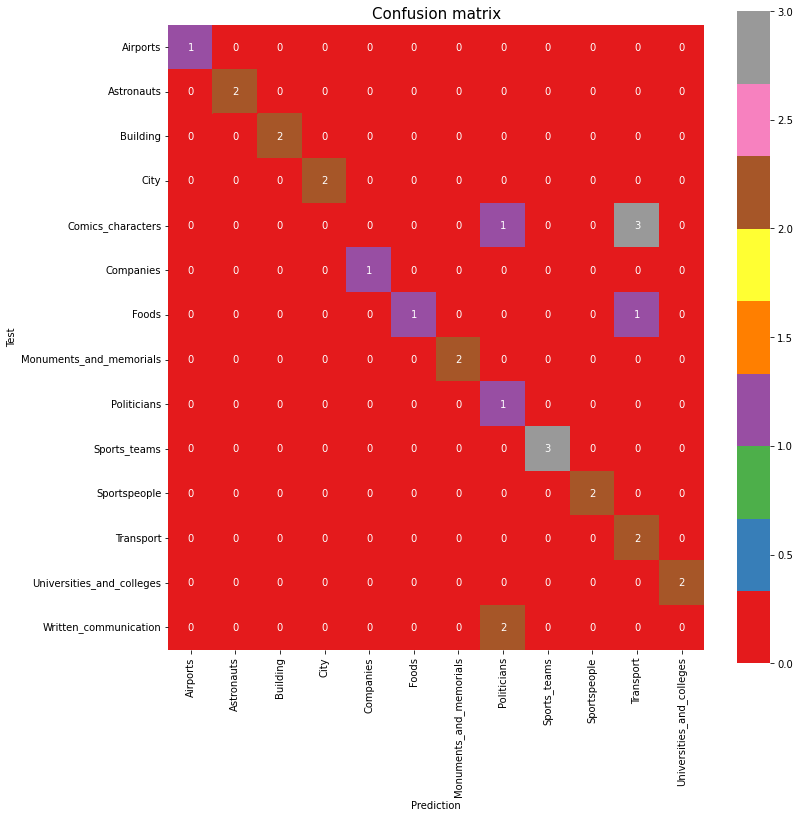

In [56]:
complete(df, x='all', max_iter=20)

Precision : 0.8809523809523808
Recall : 0.8928571428571429
F1 Score : 0.8761904761904763
Accuracy : 0.8928571428571429
Accuracy per categories : {'Comics_characters': 1.0, 'City': 1.0, 'Transport': 1.0, 'Sports_teams': 1.0, 'Sportspeople': 0.9285714285714286, 'Written_communication': 1.0, 'Universities_and_colleges': 0.9642857142857143, 'Building': 1.0, 'Astronauts': 1.0, 'Monuments_and_memorials': 1.0, 'Companies': 0.9642857142857143, 'Airports': 1.0, 'Foods': 1.0, 'Politicians': 0.9285714285714286}


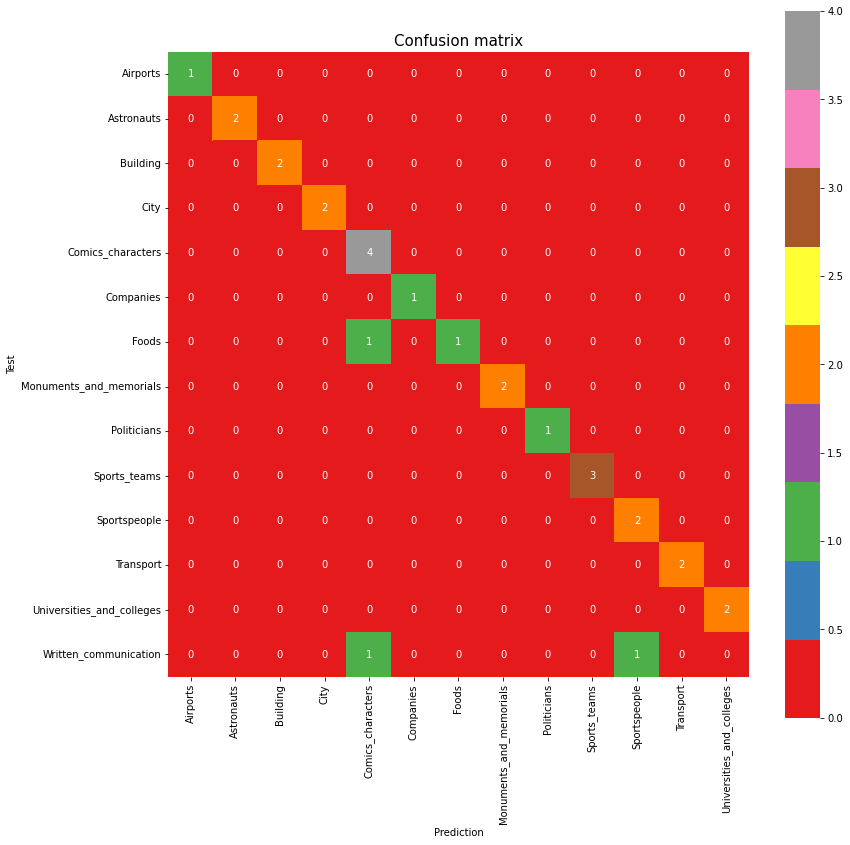

In [55]:
complete(df, x='annotated_all', max_iter=20)